Upload Dataset from Kaggle

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!pip install tensorflow

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d 'karkavelrajaj/amazon-sales-dataset'

Dataset URL: https://www.kaggle.com/datasets/karkavelrajaj/amazon-sales-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/1.95M [00:00<?, ?B/s]
100% 1.95M/1.95M [00:00<00:00, 125MB/s]


Mengekstrak Zip File Dataset

In [3]:
import zipfile

dataset_zip = zipfile.ZipFile('/content/amazon-sales-dataset.zip', 'r')
dataset_zip.extractall('/content/amazon-sales-dataset')
dataset_zip.close()

Import Semua Library

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

Analisis Data

In [5]:
# Baca dataset
file_path = '/content/amazon-sales-dataset/amazon.csv'
data = pd.read_csv('/content/amazon-sales-dataset/amazon.csv')

# Pilih kolom yang relevan
data = data[['product_name', 'category', 'about_product']]

# Gabungkan teks (`product_name` + `about_product`)
data['combined_text'] = data['product_name'] + ' ' + data['about_product']

# Hapus baris kosong
data = data.dropna()

print(f"Total data setelah pembersihan: {len(data)}")
print(data.head())

Total data setelah pembersihan: 1465
                                        product_name  \
0  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  Sounce Fast Phone Charging Cable & Data Sync U...   
3  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...   
4  Portronics Konnect L 1.2M Fast Charging 3A 8 P...   

                                            category  \
0  Computers&Accessories|Accessories&Peripherals|...   
1  Computers&Accessories|Accessories&Peripherals|...   
2  Computers&Accessories|Accessories&Peripherals|...   
3  Computers&Accessories|Accessories&Peripherals|...   
4  Computers&Accessories|Accessories&Peripherals|...   

                                       about_product  \
0  High Compatibility : Compatible With iPhone 12...   
1  Compatible with all Type C enabled devices, be...   
2  【 Fast Charger& Data Sync】-With built-in safet...   
3  The boAt Deuce USB 300 2 in 1 cable is compati...   
4  [CHARG

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_name   1465 non-null   object
 1   category       1465 non-null   object
 2   about_product  1465 non-null   object
 3   combined_text  1465 non-null   object
dtypes: object(4)
memory usage: 45.9+ KB


Preprocessing Data

In [7]:
# Representasi teks dengan TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Batasi jumlah fitur untuk neural network
X = vectorizer.fit_transform(data['combined_text'])
y = data['category']

# Encode label kategori
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Konversi ke array (TensorFlow memerlukan array, bukan sparse matrix)
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Train set: (1025, 5000), Validation set: (220, 5000), Test set: (220, 5000)


Membuat Model

In [8]:
import tensorflow as tf
import numpy as np
import random

# Set seed untuk semua library terkait
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


In [9]:
# Bangun model neural network
model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Kompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         640,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 211)                 │          13,715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 662,099 (2.53 MB)

 Trainable params: 662,099 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Training Model

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Latih model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    shuffle=False,
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.1253 - loss: 5.3108 - val_accuracy: 0.2182 - val_loss: 4.9462
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1908 - loss: 4.6073 - val_accuracy: 0.2500 - val_loss: 3.7769
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2506 - loss: 3.7266 - val_accuracy: 0.3091 - val_loss: 3.4108
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3142 - loss: 3.2771 - val_accuracy: 0.4091 - val_loss: 3.1382
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3974 - loss: 2.9428 - val_accuracy: 0.4636 - val_loss: 2.9201
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4520 - loss: 2.6546 - val_accuracy: 0.4909 - val_loss: 2.7350
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5211 - loss: 2.3901 - val_accuracy: 0.5364 - val_loss: 2.5827
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5740 - loss: 2.1545 - val_accuracy: 0.5727 - v

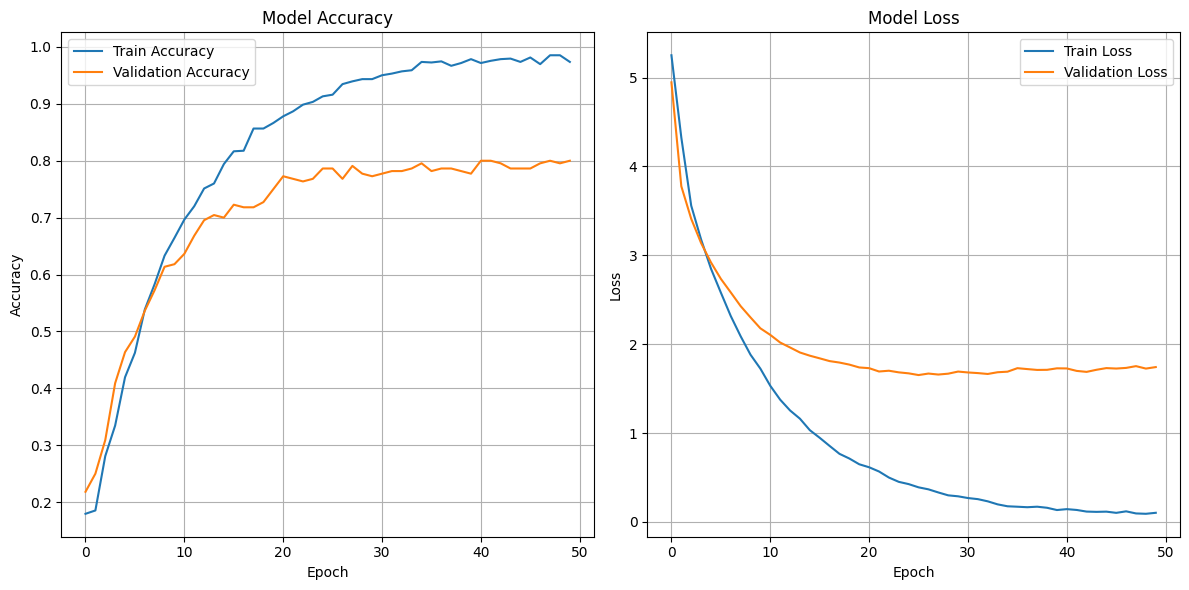

In [11]:
# Plot akurasi
plt.figure(figsize=(12, 6))

# Training dan Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Training dan Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Evaluasi Model

In [12]:
# Evaluasi di test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7726 - loss: 2.4546 
Test Loss: 2.365054130554199, Test Accuracy: 0.7863636612892151


Prediksi Model

In [13]:
# Contoh input produk
sample_text = ["samsung"]
sample_vector = vectorizer.transform(sample_text).toarray()  # Transform teks ke TF-IDF

# Prediksi kategori
predicted_category = label_encoder.inverse_transform([np.argmax(model.predict(sample_vector))])
print(f"Predicted category: {predicted_category[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted category: Electronics|HomeTheater,TV&Video|Accessories|RemoteControls


Menyimpan Model

In [14]:
# Save the entire model
model.save('model_user_category.h5')

print("Model berhasil disimpan!")

Model berhasil disimpan!


Konversi Model ke TensorFlow Lite

In [15]:
# Load the saved model
model = tf.keras.models.load_model('model_user_category.h5')

# Convert to TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model_user_category.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TensorFlow Lite!")

Saved artifact at '/tmp/tmpm4hb57c6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5000), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 211), dtype=tf.float32, name=None)
Captures:
  139928941823248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139928941829760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139928942225616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139928942222448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139928942330624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139928942330096: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil dikonversi ke TensorFlow Lite!
